In [ ]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import imutils
from skimage import exposure
from skimage import feature
from sklearn.metrics.pairwise import cosine_similarity
from google.colab.patches import cv2_imshow
from google.colab import drive

PATH_TO_DATA = "./drive/My Drive/Computer_Vision/"

In [ ]:
## Mounts Google Drive if it's not mounted yet
if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def remove_asymmetries(matches, matches2):
    sel_matches = []
    for match1 in matches:
        for match2 in matches2:
            if match1.queryIdx == match2.trainIdx and match1.trainIdx == match2.queryIdx:
                sel_matches.append(match1)
                break
    return sel_matches


def bf_matcher(descriptors1, descriptors2):
    """
        Performs Brute-Force Matching on descriptors
    """
    
    #  Acording to cv2.BFMatcher documentation found in:
    # https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html#bfmatcher-bfmatcher
    #  NORM_HAMMING should be used with ORB, BRISK and BRIEF, NORM_HAMMING2 should be used with ORB when WTA_K==3 or 4
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    raw_matches = bf.knnMatch(descriptors1, descriptors2, 2)
    raw_matches = [matches for matches in raw_matches if len(matches) == 2]  # Keeps only pair of matches
    # print("Raw matches (knn):", len(raw_matches))
    matches = []

    # loop over the raw matches
    for m,n in raw_matches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * 0.75:
            matches.append(m)

    return matches


def flann_matcher(descriptors1, descriptors2):
    # FLANN Based Matcher
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 8, # 6, 12
                       key_size = 30,     # 12, 20
                       multi_probe_level = 2) # 1, 2

    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches_flann = flann.knnMatch(descriptors1,descriptors2,k=2)
    matches_flann = [matches for matches in matches_flann if len(matches)==2] ## Keeps only pair of matches

    # ratio test as per Lowe's paper
    matches = []
    for i,(m,n) in enumerate(matches_flann):
        if m.distance < 0.7*n.distance:
            matches.append(m)

    matches = sorted(matches, key=lambda x: x.distance)

    return matches


def get_feat_keypoints(source_img, dest_img, matcher_algorithm=None):
    """
      Performs both feature detection and description.
      Returns the keypoints of source_img and dest_img that have higher similarity between each other.
    """
    MATCH_ALGORITHMS = {'bf': bf_matcher, 'flann': flann_matcher}

    resize_ratio = 0.3 

    new_x, new_y = [int(dim * resize_ratio) for dim in source_img.shape]

    # Image downscale for accuracy improvement 
    source_img = cv2.resize(source_img, (new_x, new_y), interpolation=cv2.INTER_AREA)
    dest_img = cv2.resize(dest_img, (new_x, new_y), interpolation=cv2.INTER_AREA)

    # Initiate ORB detector with a maximum of 500 features and even considering image borders
    orb = cv2.ORB_create(nfeatures=500, edgeThreshold=0, WTA_K=2)

    # Find the keypoints and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(source_img, None)
    keypoints2, descriptors2 = orb.detectAndCompute(dest_img, None)

    if matcher_algorithm in MATCH_ALGORITHMS:
        feature_matcher = MATCH_ALGORITHMS[matcher_algorithm]
    else:
        feature_matcher = MATCH_ALGORITHMS['bf']

    # Apply feature matching
    matches1 = feature_matcher(descriptors1, descriptors2)
    matches2 = feature_matcher(descriptors2, descriptors1)

    # Keeps only symmetric matches
    matches = remove_asymmetries(matches1, matches2)

    # Draw top matches
    imMatches = cv2.drawMatches(source_img, keypoints1, dest_img, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite("matches.jpg", imMatches)
    
    # Extract the coordinate pairs from good matches and resize them to original dimension
    src_pts = np.float32([[dim/resize_ratio for dim in keypoints1[m.queryIdx].pt] for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([[dim/resize_ratio for dim in keypoints2[m.trainIdx].pt] for m in matches]).reshape(-1,1,2)

    return src_pts, dst_pts

In [ ]:
def align_image(source_img, dest_img):

    src_pts, dst_pts = get_feat_keypoints(source_img, dest_img, matcher_algorithm='bf')

    # Calculate Homography
    # Feature matching don't always find the best matches,so we need to use
    # a robust estimation technique called Random Sample Consensus (RANSAC)
    # that can calculate good results even with mediocre matches
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = source_img.shape 

    new_shape = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Performs the perspective matrix transformation of vectors based on previously calculated homography 'M' and the new shape    
    dst = cv2.perspectiveTransform(new_shape, M)

    # Calculates perspective transform from four pairs of the corresponding points gotten from previous calculation 
    new_perspective = cv2.getPerspectiveTransform(np.float32(dst), new_shape)

    # Performs perspective transformation on target image
    transformed_image = cv2.warpPerspective(dest_img, new_perspective, (w,h), borderValue=255)

    return transformed_image, M

In [ ]:
def remove_borders(image):
    BORDER_LENGTH = 12  # Amount of pixels to be removed from borders

    # Creates a mask with zeroed borders of 12-pixel thickness
    mask = np.zeros_like(image)
    mask[BORDER_LENGTH:-BORDER_LENGTH, BORDER_LENGTH:-BORDER_LENGTH] = 1

    return image * mask  # Apply and return new image


def diff_and_morph(target_image, reff_image, kernel_shape=None, kernel_dim=5):

    MORPHOLOGY_KERNELS = {'rect': cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_dim,kernel_dim)),
               'ellipse': cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_dim,kernel_dim)),
               'cross': cv2.getStructuringElement(cv2.MORPH_CROSS,(kernel_dim,kernel_dim))}
    
    difference = cv2.absdiff(target_image, reff_image)  # Absolute difference between both images
    
    difference = remove_borders(difference)

    if kernel_shape in MORPHOLOGY_KERNELS:
        kernel = MORPHOLOGY_KERNELS[kernel_shape]
    else:
        kernel = MORPHOLOGY_KERNELS['cross']

    # Removes some imperfections due to potential jagged edges on image
    difference = cv2.erode(difference, kernel, iterations=3)  # Apply erosion 
    difference = cv2.dilate(difference, kernel, iterations=3)  # Apply dilation
    difference = np.where(difference != 0, 255, difference)

    return difference

def apply_hog(figure):
     hog = feature.hog(figure, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), transform_sqrt=False, 
                        block_norm="L1", visualize=False)
     
     return hog

def apply_bounding_boxes(image, bounding_boxes, color=(0,0,255)):

    delta = 5

    image = image.copy()

    _, image = cv2.threshold(image,100,255,cv2.THRESH_BINARY) # Threshold image

    if len(image.shape) < 3: # If image is single channel
        image = np.stack((image,)*3, axis=-1)

    for bounding_box in bounding_boxes:
        (x, y, w, h) = bounding_box 
        cv2.rectangle(image, (x-delta, y-delta), (x+w+delta, y+h+delta), color, 4)

    return image

def analyse_difference(source_img, diff_image): 

    # Finds the contours of white objects on diff_image 
    cnts = cv2.findContours(diff_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Heuristics for histogram similarity calculation
    COMPARISON_HEURISTICS = {"Correlation": cv2.HISTCMP_CORREL,
                    "Chi-Squared": cv2.HISTCMP_CHISQR,
                    "Intersection": cv2.HISTCMP_INTERSECT,
                    "Bhattacharyya": cv2.HISTCMP_BHATTACHARYYA,
                    "Hellinger": cv2.HISTCMP_HELLINGER,
                    "KL-DIV": cv2.HISTCMP_KL_DIV}

    bounding_boxes = []

    has_defects = False

    for c in reversed(cnts):
        # Compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)   

        # Copies a patch from both source_img and diff_image corresponding 
        # to the bounding boxes gotten from previous step 
        patch1 = source_img[y:y + h, x:x + w]
        patch2 = diff_image[y:y + h, x:x + w]
        
        # Resize to 2x1 aspect ratio
        patch1 = cv2.resize(patch1, (64, 128), interpolation=cv2.INTER_AREA)
        patch2 = cv2.resize(patch2, (64, 128), interpolation=cv2.INTER_AREA)

        # Calculates the Histogram of Oriented Gradients (HoG) of the two patches
        H1 = apply_hog(patch1)
        H2 = apply_hog(patch2)

        # Measures how much the two HoG's are similar
        divergence = cv2.compareHist(np.float32(H2), np.float32(H1), COMPARISON_HEURISTICS['Hellinger'])
        
        # If divergence is above a threshold (depends on the method chosen in OPENCV_METHODS) then
        # append bounding box to list of defect spatial locations
        if divergence > 0.1:
            has_defects = True
            bounding_boxes.append((x, y, w, h))  

    return bounding_boxes, has_defects

def detect(source_img, dest_img):

    _, source_img = cv2.threshold(source_img,100,255,cv2.THRESH_BINARY) # Threshold image
    _, dest_img = cv2.threshold(dest_img,100,255,cv2.THRESH_BINARY) # Threshold image

    aligned_image, _ = align_image(source_img, dest_img)

    difference = diff_and_morph(aligned_image, source_img, kernel_shape='ellipse', kernel_dim=kernel_dim)

    bounding_boxes, has_defects = analyse_difference(source_img, difference)

    defects = apply_bounding_boxes(dest_img, bounding_boxes)

    return defects, has_defects


This PCB is a faulty one? True


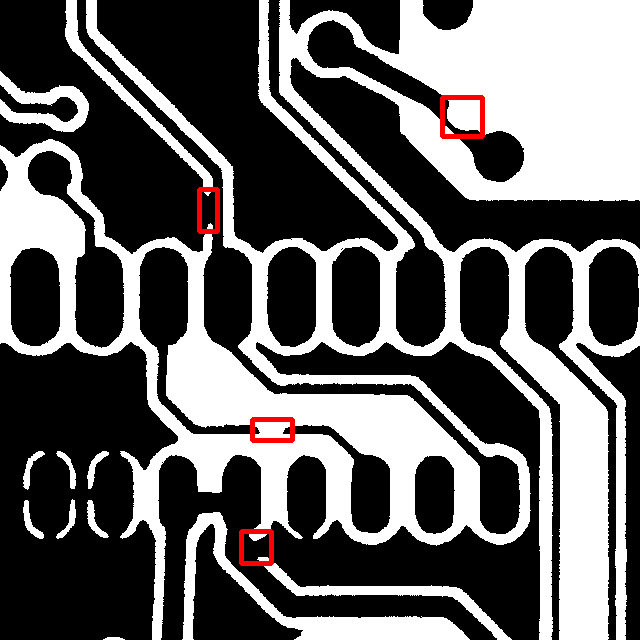

In [ ]:
## MAIN

img_number = [1, 1] # Image id

kernel_dim = 3 # Kernel dimension of morphological transformations (erosion, dilation)

source_img = cv2.imread(os.path.join(PATH_TO_DATA, f"data_notebooks/crop_img2_fotolito/placa_{img_number[0]}_{img_number[1]}.png"), cv2.IMREAD_GRAYSCALE)

dest_img = cv2.imread(os.path.join(PATH_TO_DATA, f"data_notebooks/crop_img2_defeito/placa_{img_number[0]}_{img_number[1]}.png"), cv2.IMREAD_GRAYSCALE)

defects, has_defects = detect(source_img, dest_img)

print(f'This PCB is a faulty one? {has_defects}')

cv2_imshow(defects)

# Write aligned image to disk. 
# outFilename = "aligned.jpg"
# print("Saving aligned image : ", outFilename); 
# cv2.imwrite(outFilename, im1Reg)

# Print estimated homography
# print("Estimated homography : \n",  h)